## Motor Imagery Classification from Dataset

In [7]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mne.decoding import CSP
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline

import moabb
from moabb.datasets import BNCI2014_001
from moabb.evaluations import WithinSessionEvaluation
from moabb.paradigms import LeftRightImagery


moabb.set_log_level("info")
warnings.filterwarnings("ignore")

<frozen importlib._bootstrap>:219: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:219: FutureWarning: mne.io.pick.pick_channels_regexp is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:219: FutureWarning: mne.io.pick.channel_type is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.


To use the get_shape_from_baseconcar, InputShapeSetterEEG, BraindecodeDatasetLoaderyou need to install `braindecode`.`pip install braindecode` or Please refer to `https://braindecode.org`.


C:\Users\danie\AppData\Roaming\Python\Python38\site-packages\moabb\pipelines\__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(


### Instantiate Dataset

In [8]:
dataset = BNCI2014_001()
dataset.subject_list = [1, 2, 3]

### Access EEG Recordings

In [9]:
sessions = dataset.get_data(subjects=[1])

In [10]:
subject = 1
session_name = "0train"
run_name = "0"

sessions[subject][session_name][run_name]

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,25 points
Good channels,"22 EEG, 3 EOG, 1 Stimulus"
Bad channels,None
EOG channels,"EOG1, EOG2, EOG3"
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.00 Hz
Lowpass,125.00 Hz


### Set Up Paradigm

In [13]:
dataset.paradigm

'imagery'

In [14]:
paradigm = LeftRightImagery()

In [15]:
paradigm.datasets

### Get data

In [16]:
X, labels, meta = paradigm.get_data(dataset=dataset, subjects=[1])
y = [0 if label == "left_hand" else 1 for label in labels]

In [17]:
X.shape

(288, 22, 1001)

### Create Pipeline

In [22]:
pipeline = {}
pipeline["CSP+LDA"] = make_pipeline(CSP(n_components=8), LDA())

In [23]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(pipeline["CSP+LDA"], X, y, cv=5)
scores

array([0.82758621, 0.86206897, 0.87931034, 0.92982456, 0.87719298])

# Motor Imagery Classification via Natus

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import json

json_file_path = "../clients/logs/motor_imagery/data_20240709_150021.json"

with open(json_file_path) as f:
    data = json.load(f)

In [66]:
X = []

for batch in data["samples"]:
    X.append(np.transpose(batch))

X = np.array(X)
y = np.array([0 if cue == "Left Hand" else 1 for cue in data["cues"]])

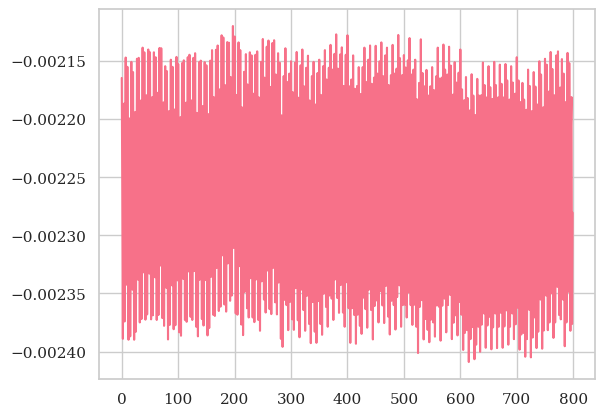

In [79]:
plt.plot(X[0, 0, :])

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from mne.decoding import CSP
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


pipeline = {}
pipeline["CSP+LDA"] = make_pipeline(CSP(n_components=8), LDA())

scores = cross_val_score(pipeline["CSP+LDA"], X, y, cv=5)
scores

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\danie\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\danie\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\danie\AppData\Roaming\Python\Python38\site-packages\sklearn\pipeline.py", line 423, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\danie\AppData\Roaming\Python\Python38\site-packages\sklearn\pipeline.py", line 377, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\danie\miniconda3\envs\zeromq\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\danie\AppData\Roaming\Python\Python38\site-packages\sklearn\pipeline.py", line 957, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "C:\Users\danie\AppData\Roaming\Python\Python38\site-packages\mne\decoding\csp.py", line 252, in fit_transform
    return super().fit_transform(X, y=y, **fit_params)
  File "C:\Users\danie\AppData\Roaming\Python\Python38\site-packages\mne\decoding\mixin.py", line 33, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
  File "C:\Users\danie\AppData\Roaming\Python\Python38\site-packages\mne\decoding\csp.py", line 191, in fit
    eigen_vectors, eigen_values = self._decompose_covs(covs, sample_weights)
  File "C:\Users\danie\AppData\Roaming\Python\Python38\site-packages\mne\decoding\csp.py", line 569, in _decompose_covs
    eigen_values, eigen_vectors = eigh(covs[0], covs.sum(0))
  File "c:\Users\danie\miniconda3\envs\zeromq\lib\site-packages\scipy\linalg\_decomp.py", line 594, in eigh
    raise LinAlgError('The leading minor of order {} of B is not '
numpy.linalg.LinAlgError: The leading minor of order 4 of B is not positive definite. The factorization of B could not be completed and no eigenvalues or eigenvectors were computed.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\danie\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\danie\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\danie\AppData\Roaming\Python\Python38\site-packages\sklearn\pipeline.py", line 423, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\danie\AppData\Roaming\Python\Python38\site-packages\sklearn\pipeline.py", line 377, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\danie\miniconda3\envs\zeromq\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\danie\AppData\Roaming\Python\Python38\site-packages\sklearn\pipeline.py", line 957, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "C:\Users\danie\AppData\Roaming\Python\Python38\site-packages\mne\decoding\csp.py", line 252, in fit_transform
    return super().fit_transform(X, y=y, **fit_params)
  File "C:\Users\danie\AppData\Roaming\Python\Python38\site-packages\mne\decoding\mixin.py", line 33, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
  File "C:\Users\danie\AppData\Roaming\Python\Python38\site-packages\mne\decoding\csp.py", line 191, in fit
    eigen_vectors, eigen_values = self._decompose_covs(covs, sample_weights)
  File "C:\Users\danie\AppData\Roaming\Python\Python38\site-packages\mne\decoding\csp.py", line 569, in _decompose_covs
    eigen_values, eigen_vectors = eigh(covs[0], covs.sum(0))
  File "c:\Users\danie\miniconda3\envs\zeromq\lib\site-packages\scipy\linalg\_decomp.py", line 594, in eigh
    raise LinAlgError('The leading minor of order {} of B is not '
numpy.linalg.LinAlgError: The leading minor of order 5 of B is not positive definite. The factorization of B could not be completed and no eigenvalues or eigenvectors were computed.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\danie\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\danie\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\danie\AppData\Roaming\Python\Python38\site-packages\sklearn\pipeline.py", line 423, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\danie\AppData\Roaming\Python\Python38\site-packages\sklearn\pipeline.py", line 377, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\danie\miniconda3\envs\zeromq\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\danie\AppData\Roaming\Python\Python38\site-packages\sklearn\pipeline.py", line 957, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "C:\Users\danie\AppData\Roaming\Python\Python38\site-packages\mne\decoding\csp.py", line 252, in fit_transform
    return super().fit_transform(X, y=y, **fit_params)
  File "C:\Users\danie\AppData\Roaming\Python\Python38\site-packages\mne\decoding\mixin.py", line 33, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
  File "C:\Users\danie\AppData\Roaming\Python\Python38\site-packages\mne\decoding\csp.py", line 191, in fit
    eigen_vectors, eigen_values = self._decompose_covs(covs, sample_weights)
  File "C:\Users\danie\AppData\Roaming\Python\Python38\site-packages\mne\decoding\csp.py", line 569, in _decompose_covs
    eigen_values, eigen_vectors = eigh(covs[0], covs.sum(0))
  File "c:\Users\danie\miniconda3\envs\zeromq\lib\site-packages\scipy\linalg\_decomp.py", line 594, in eigh
    raise LinAlgError('The leading minor of order {} of B is not '
numpy.linalg.LinAlgError: The leading minor of order 8 of B is not positive definite. The factorization of B could not be completed and no eigenvalues or eigenvectors were computed.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\danie\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\danie\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\danie\AppData\Roaming\Python\Python38\site-packages\sklearn\pipeline.py", line 423, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\danie\AppData\Roaming\Python\Python38\site-packages\sklearn\pipeline.py", line 377, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\danie\miniconda3\envs\zeromq\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\danie\AppData\Roaming\Python\Python38\site-packages\sklearn\pipeline.py", line 957, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "C:\Users\danie\AppData\Roaming\Python\Python38\site-packages\mne\decoding\csp.py", line 252, in fit_transform
    return super().fit_transform(X, y=y, **fit_params)
  File "C:\Users\danie\AppData\Roaming\Python\Python38\site-packages\mne\decoding\mixin.py", line 33, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
  File "C:\Users\danie\AppData\Roaming\Python\Python38\site-packages\mne\decoding\csp.py", line 191, in fit
    eigen_vectors, eigen_values = self._decompose_covs(covs, sample_weights)
  File "C:\Users\danie\AppData\Roaming\Python\Python38\site-packages\mne\decoding\csp.py", line 569, in _decompose_covs
    eigen_values, eigen_vectors = eigh(covs[0], covs.sum(0))
  File "c:\Users\danie\miniconda3\envs\zeromq\lib\site-packages\scipy\linalg\_decomp.py", line 594, in eigh
    raise LinAlgError('The leading minor of order {} of B is not '
numpy.linalg.LinAlgError: The leading minor of order 6 of B is not positive definite. The factorization of B could not be completed and no eigenvalues or eigenvectors were computed.
